In [59]:
import pandas as pd
import numpy as np
import io
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
from tqdm import tqdm
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading of the data from the .csv file.

In [61]:
df = pd.read_csv('Tweets.csv')
df

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $30 a fligh...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
11536,negative,@AmericanAir my flight was Cancelled Flightled...
11537,negative,@AmericanAir right on cue with the delays👌
11538,positive,@AmericanAir thank you we got on a different f...
11539,negative,@AmericanAir leaving over 20 minutes Late Flig...


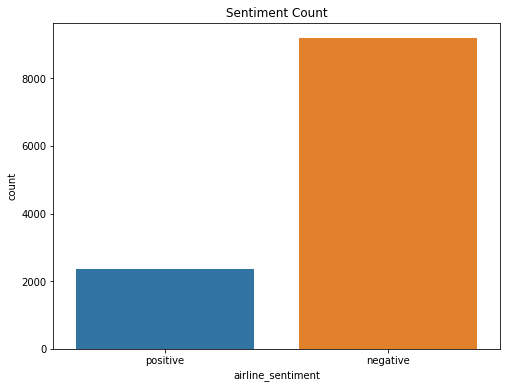

In [62]:
plt.figure(figsize = (8,6))
sns.countplot(x = 'airline_sentiment', data = df)
plt.title("Sentiment Count")
plt.show()

### Suitable data preparation steps for NLP data

In [63]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words which will be easy for further processing '''
    TweetText = tweet.lower() # converting every tweet to lower case. 
    TweetText = re.sub(r"[^a-zA-Z0-9]", " ", TweetText) # remving charaters that are not letters.
    words = TweetText.split() # tokenization
    words = [w for w in words if w not in stopwords.words("english")] # removing all stop words
    words = [PorterStemmer().stem(w) for w in words] # stemming
    return words

In [64]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet_to_words(str(item))
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 11541/11541 [00:30<00:00, 379.74it/s]


,airline_sentiment,text,cleantext
0,positive,@VirginAmerica plus you've added commercials t...,"[virginamerica, plu, ad, commerci, experi, tacki]"
1,negative,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi..."
2,negative,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, big, bad, thing]"
3,negative,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, serious, would, pay, 30, fligh..."
4,positive,"@VirginAmerica yes, nearly every time I fly VX...","[virginamerica, ye, nearli, everi, time, fli, ..."
...,...,...,...
11536,negative,@AmericanAir my flight was Cancelled Flightled...,"[americanair, flight, cancel, flightl, leav, t..."
11537,negative,@AmericanAir right on cue with the delays👌,"[americanair, right, cue, delay]"
11538,positive,@AmericanAir thank you we got on a different f...,"[americanair, thank, got, differ, flight, chic..."
11539,negative,@AmericanAir leaving over 20 minutes Late Flig...,"[americanair, leav, 20, minut, late, flight, w..."


In [65]:
def unlist(list):
  """ Converting list ento element with space seperation to make processing easy"""
  words=''
  for item in list:
      words+=item+' '
  return words

In [66]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [67]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["Vader_Negative"] =  df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["Vader_Neutral"] =  df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["Vader_Positive"] =  df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["Vader_Comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [68]:
df2 = compute_vader_scores(df,'cleantext')
df2

,airline_sentiment,text,cleantext,Vader_Negative,Vader_Neutral,Vader_Positive,Vader_Comp,cleantext2
0,positive,@VirginAmerica plus you've added commercials t...,"[virginamerica, plu, ad, commerci, experi, tacki]",0.000,1.000,0.000,0.0000,virginamerica plu ad commerci experi tacki
1,negative,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi...",0.169,0.662,0.169,0.0000,virginamerica realli aggress blast obnoxi ente...
2,negative,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, big, bad, thing]",0.467,0.533,0.000,-0.5423,virginamerica realli big bad thing
3,negative,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, serious, would, pay, 30, fligh...",0.352,0.511,0.136,-0.4215,virginamerica serious would pay 30 flight seat...
4,positive,"@VirginAmerica yes, nearly every time I fly VX...","[virginamerica, ye, nearli, everi, time, fli, ...",0.000,1.000,0.000,0.0000,virginamerica ye nearli everi time fli vx ear ...
...,...,...,...,...,...,...,...,...
11536,negative,@AmericanAir my flight was Cancelled Flightled...,"[americanair, flight, cancel, flightl, leav, t...",0.125,0.875,0.000,-0.2500,americanair flight cancel flightl leav tomorro...
11537,negative,@AmericanAir right on cue with the delays👌,"[americanair, right, cue, delay]",0.434,0.566,0.000,-0.3182,americanair right cue delay
11538,positive,@AmericanAir thank you we got on a different f...,"[americanair, thank, got, differ, flight, chic...",0.000,0.667,0.333,0.3612,americanair thank got differ flight chicago
11539,negative,@AmericanAir leaving over 20 minutes Late Flig...,"[americanair, leav, 20, minut, late, flight, w...",0.085,0.915,0.000,-0.1027,americanair leav 20 minut late flight warn com...


In [69]:
df2['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [70]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
#cocverting the positive and negative sentiment into binary value. 
BinaryCol = ['airline_sentiment']
def label_encoder(df2, binary_col):
    labelencoder = LabelEncoder()
    df[binary_col] = labelencoder.fit_transform(df[binary_col])
    return df
for column in BinaryCol:
    label_encoder(df2, column)

In [71]:
df2 = df2[['airline_sentiment', 'cleantext2']]
df2

,airline_sentiment,cleantext2
0,1,virginamerica plu ad commerci experi tacki
1,0,virginamerica realli aggress blast obnoxi ente...
2,0,virginamerica realli big bad thing
3,0,virginamerica serious would pay 30 flight seat...
4,1,virginamerica ye nearli everi time fli vx ear ...
...,...,...
11536,0,americanair flight cancel flightl leav tomorro...
11537,0,americanair right cue delay
11538,1,americanair thank got differ flight chicago
11539,0,americanair leav 20 minut late flight warn com...


## Support Vector Machine

In [72]:
Vectorizerr = TfidfVectorizer(use_idf=True, lowercase=True) # Creating object of TF-IDF vectorizer
X_Tf_Df= Vectorizerr.fit_transform(df2.cleantext2)

# Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X_Tf_Df, df2['airline_sentiment'], random_state=42)

In [73]:
SVM = svm.SVC(probability=True)
SVMmodel=SVM.fit(x_train, y_train)
Predicted=SVMmodel.predict(x_test)
test_probs = SVMmodel.predict_proba(x_test)
test_probs = test_probs[:, 1]
yhat = SVMmodel.predict(x_test)

In [74]:
confusion_matrix = metrics.confusion_matrix(y_test, Predicted)

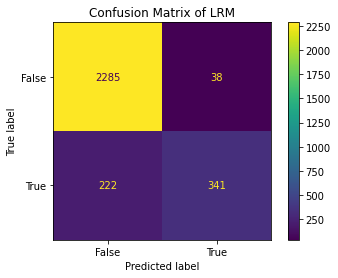

In [75]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.title("Confusion Matrix of LRM")
plt.show() 

In [76]:
print(classification_report(y_test,Predicted)) 


              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2323
           1       0.90      0.61      0.72       563

    accuracy                           0.91      2886
   macro avg       0.91      0.79      0.84      2886
weighted avg       0.91      0.91      0.90      2886



In [77]:
score = SVMmodel.score(x_test,y_test)
print('Test Accuracy is', round(score*100,2),"%")

Test Accuracy is 90.99 %


## Neural Network

In [78]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Activation, Embedding, Dropout

In [79]:
clean_text  = df2['cleantext2'].tolist()


In [80]:
earlystop = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, verbose=1, mode='auto')
callbacks_list = [earlystop]
df2['text'] = clean_text
total=0

In [81]:
for t in range (0,5):
     cv=10
     k = [int((len(df2['text']))/cv*j) for j in range(cv+1)]
     X_test, y_test= df2['text'][k[t]:k[t+1]], df2['airline_sentiment'][k[t]:k[t+1]]
     X_train, y_train =pd.concat([df2['text'][:k[t]],df2['text'][k[t+1]:]]), pd.concat([df2['airline_sentiment'][:k[t]],df2['airline_sentiment']  [k[t+1]:]])
     nb_classes = 3
     train_data=[]
     for i in X_train:
        train_data.append(i)
     test_data=[]
     for i in X_test:
        test_data.append(i)
     Token = Tokenizer(num_words=10000)

     # Splitting into training and testing
     X_train = Token.fit_on_texts(train_data)
     X_test = Token.fit_on_texts(test_data)
     X_train = Token.texts_to_matrix(train_data,mode='binary')
     X_test = Token.texts_to_matrix(test_data,mode='binary')
     
     from keras.utils import to_categorical
     y_train = to_categorical(y_train, nb_classes)
     y_test = to_categorical(y_test, nb_classes)

     # Training Models
     modelNN = Sequential()
     modelNN.add(Dense(10, input_shape=(10000,)))
     modelNN.add(Activation('relu'))
     modelNN.add(Dropout(0.5))
     modelNN.add(Dense(3))
     modelNN.add(Activation('softmax'))
     modelNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
     modelNN.fit(X_train, y_train,epochs=10, batch_size=32,callbacks = callbacks_list, validation_split=0.1)
     score = modelNN.evaluate(X_test, y_test,batch_size=32, verbose=1)
     print("The evaluation score is = ", score)

Epoch 1/10
293/293 [==============================] - 2s 6ms/step - loss: 0.5999 - accuracy: 0.8205 - val_loss: 0.2222 - val_accuracy: 0.9365
Epoch 2/10
293/293 [==============================] - 2s 5ms/step - loss: 0.3328 - accuracy: 0.8779 - val_loss: 0.1662 - val_accuracy: 0.9461
Epoch 3/10
293/293 [==============================] - 2s 6ms/step - loss: 0.2652 - accuracy: 0.8955 - val_loss: 0.1501 - val_accuracy: 0.9480
Epoch 4/10
293/293 [==============================] - 2s 5ms/step - loss: 0.2331 - accuracy: 0.9056 - val_loss: 0.1448 - val_accuracy: 0.9471
Epoch 5/10
293/293 [==============================] - 2s 6ms/step - loss: 0.2001 - accuracy: 0.9207 - val_loss: 0.1430 - val_accuracy: 0.9432
Epoch 6/10
293/293 [==============================] - 2s 6ms/step - loss: 0.1745 - accuracy: 0.9330 - val_loss: 0.1486 - val_accuracy: 0.9451
Epoch 7/10
293/293 [==============================] - 2s 5ms/step - loss: 0.1621 - accuracy: 0.9443 - val_loss: 0.1523 - val_accuracy: 0.9471
Epoch 

--- 

This cell goes to the very bottom of your submitted notebok.
You are requried to link the sources and web-links that you have used for various parts of this coursework. 

Write them sources used in the following format similar to the first examle in the sources list below :

    - what you have used them for : web-link

Sources:

- Implement a recurrent neural network : https://peterroelants.github.io/posts/rnn-implementation-part01/